## 03- Entrenamiento del Modelo

En este notebook realizaremos los procedimientos necesarios para entrenar el modelo que permita establecer la probabilidad de que un cliente no renueve su producto con la compañía, basado en las diferentes dimensiones de información que se tengan del mismo al momento de emitir la póliza y que hemos explorado en los notebooks anteriores. Para ello usaremos las ventajas de la librería `scikit-learn`.

In [1]:
from model_parameters import *
import pandas as pd
import numpy as np
from utils import metrics,get_confusion_plot
from sklearn.metrics import roc_auc_score
data=pd.read_csv("data_modelacion.csv",sep=";",dtype={'Asegurado__c':str,'NumeroPoliza__c':str,'CodigoTipoAsegurado__c':str,'churn':int,'ClaseVehiculo__c':str,'TipoVehiculo__c':str,'PuntoVenta__c':str,'MarcaVehiculo__c':str}).drop(columns=['NumeroPoliza__c'])

## Revisar Balanceo de Datos

Como podemos observar, la proporción de clientes que no renovaron su poliza son mucho menores respecto a los que si lo hicieron. Este desbalanceo en la data toma importancia al momento de analizar las métricas de un modelo. Por tanto, es vital utilizar métricas que no sean sensibles al desbalanceo de clases en la información de entrenamiento. Para ello existen además, algunas técnicas como disminuir la información de la clase mayoritaria (undersampling) o incluso generar instancias de la clase minoritaria a partir de algoritmos que utilizan K-nearest neighbors (ver [Adasyn](http://glemaitre.github.io/imbalanced-learn/auto_examples/over-sampling/plot_adasyn.html) o [SMOTE](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html))

In [35]:
data.churn.value_counts(normalize=True)*100

0    83.931122
1    16.068878
Name: churn, dtype: float64

## Generar Particiones de Datos

Se debe generar una partición de la data para test(10%), el restante se usará para entrenamiento y validación.

In [2]:
#Definir esquema para valores faltantes
num_cols=[i for i in data.columns.values.tolist() if data[i].dtype!="O" and i not in ['churn','Profesion__pc','Asegurado__c','CodigoTipoAsegurado__c','PuntoVenta__c','RamoTecnico__c','Tipo_poliza_c']]
str_cols=[i for i in data.columns.values.tolist() if data[i].dtype not in ["int32","float","int64"] and i not in ['churn','NumeroPoliza__c','Producto__c','Asegurado__c','CodigoTipoAsegurado__c','PuntoVenta__c','RamoTecnico__c','Tipo_poliza_c']]
train,test=train_test_split(data, test_size=0.10,random_state=123)

In [3]:
##guardar train y test para reproducibilidad
train.to_csv("train.csv",sep=";",index=False)
test.to_csv("test.csv",sep=";",index=False)

## Modelos a Evaluar

Se procede a evaluar dos tipos de modelos de tipo boosting (XGboost,LightGBM), los cuales son ampliamente usados en el modelamiento predictivo. A su vez, se prueba un modelo sencillo como la regresión logística, para comparar el desempeño frente a modelos de mayor complejidad. El objetivo general de esta comparación es establecer qué tipo de modelo puede encontrar los aspectos más relevantes para establecer cuándo un cliente tiene mayor propensión a renovar su producto con la compañía.

In [7]:
from sklearn import set_config
set_config(display='diagram')

In [4]:
# La variable punto de venta tiene más de 1300 categorías, por lo tanto, al tener la ciudad de venta recategorizada, se procede a generar la base de entrenamiento de esta en lugar del punto de venta.
X_train,Y_train=train.drop(columns=["churn","Asegurado__c","PuntoVenta__c"]),train['churn'].values

In [5]:
## Pasos de imputación y estandarización

from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import FunctionTransformer

##función custom para pasar de string a categoría
def to_category(x):
  return pd.DataFrame(x).astype("category")

#CategoryTransformer = FunctionTransformer(to_category)


def get_classifier_model(model_name:str,k_cv:int=5,scoring="f1",imputer="zero",scaler_method="standard",one_hot_str=True) -> GridSearchCV:
    """retorna un objeto GridSearchCV para entrenar con @param model_name y k_cv-fold Cross Validation
    para clasificación binaria, la métrica de scoring de los modelos está dada por @param scoring
    @param imputer: str | "zero" usa como enfoque de imputación poner 0 a los valores perdidos, otro valor usa el enfoque de asignar la mediana.
    @param scaler_method: str | "standard" define StandardScaler para escalar variables numéricas, minmax lo define como MinMaxScaler, None no imputa los valores
    @param enable_str_tf: Boolean | True activa one-hot-encoding para las variables categóricas
    """

    scl=StandardScaler() if scaler_method=="standard" else MinMaxScaler()

    if imputer=="zero":
        imp=SimpleImputer(strategy="constant",fill_value=0)
        num_transformer = Pipeline(
        steps=[("imputer", imp), ("scaler",scl)]
        ) 
    elif imputer=="median":
        imp=SimpleImputer(strategy="median")
        num_transformer = Pipeline(
        steps=[("imputer", imp), ("scaler",scl)]
        )
    else:
        num_transformer = Pipeline(
        steps=[("scaler",scl)]
        )

    if one_hot_str:
        cat_transformer = OneHotEncoder(handle_unknown="ignore")
        preprocessor = ColumnTransformer(
        transformers=[
            ("num", num_transformer,  num_cols), ## excluir las variables tipo objeto y dejar las numéricas
            ("cat", cat_transformer, str_cols),  ##incluir solo las variables tipo objeto
        ],sparse_threshold=0
    )
    else:
        preprocessor = ColumnTransformer(
        transformers=[
            ("num", num_transformer,  num_cols), ## excluir las variables tipo objeto y dejar las numéricas
            ("cat", SimpleImputer(strategy="constant",fill_value="otros"), str_cols),  ##incluir solo las variables tipo objeto
        ],sparse_threshold=0
    )
    
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", num_transformer,  num_cols), ## excluir las variables tipo objeto y dejar las numéricas
            ("cat", cat_transformer, str_cols),  ##incluir solo las variables tipo objeto
        ],sparse_threshold=0
    )

    model=MODEL_LIST[model_name]
    pipe=Pipeline([
        ('cleaner',preprocessor),
        ('pca',PCA()),
        ('model',model)

    ], verbose=True)

    param_grid=MODEL_PARAMS[model_name]['param_grid']

    grid=GridSearchCV(pipe,param_grid,cv=k_cv,refit=True,scoring=scoring,verbose=True,n_jobs=-1)
    return grid

xgb=get_classifier_model("xgboost")
logistic=get_classifier_model("logistic_regression")
lightgbm=get_classifier_model("lightgbm")

In [26]:
logistic.fit(X_train,Y_train.ravel())

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[Pipeline] ........... (step 1 of 3) Processing cleaner, total=   0.1s
[Pipeline] ............... (step 2 of 3) Processing pca, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing model, total=  37.5s


C:\Users\jhonp\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cleaner',
                                        ColumnTransformer(sparse_threshold=0,
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value=0,
                                                                                                        strategy='constant')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['n_prod_prev',
                                                                          'total_siniestros',
                                                                          'total_pagado_smmlv',
                                                                          'anios_ultimo_siniestro',
                                                                          'Activos__c',
                                                                          'AnnualRevenue',
                                                                          'MontoAnual__c',
                                                                          'Otros...
                                                                          'tipo_prod_desc',
                                                                          'ClaseVehiculo__c',
                                                                          'TipoVehiculo__c',
                                                                          'EstadoCivil__pc',
                                                                          'Genero__pc',
                                                                          'ciudad_name'])])),
                                       ('pca', PCA()),
                                       ('model',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=4000,
                                                           solver='saga'))],
                                verbose=True),
             n_jobs=-1,
             param_grid={'model__l1_ratio': [0.1, 0.3, 0.5, 0.8, 1],
                         'model__penalty': ['elasticnet'],
                         'pca__n_components': [10, 20]},
             scoring='f1', verbose=True)

In [27]:
lightgbm.fit(X_train,Y_train.ravel())

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits
[Pipeline] ........... (step 1 of 3) Processing cleaner, total=   0.1s
[Pipeline] ............... (step 2 of 3) Processing pca, total=   0.2s
[Pipeline] ............. (step 3 of 3) Processing model, total=   0.8s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cleaner',
                                        ColumnTransformer(sparse_threshold=0,
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value=0,
                                                                                                        strategy='constant')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['n_prod_prev',
                                                                          'total_siniestros',
                                                                          'total_pagado_smmlv',
                                                                          'anios_ultimo_siniestro',
                                                                          'Activos__c',
                                                                          'AnnualRevenue',
                                                                          'MontoAnual__c',
                                                                          'Otros...
                                       ('pca', PCA()),
                                       ('model', LGBMClassifier())],
                                verbose=True),
             n_jobs=-1,
             param_grid={'model__colsample_bytree': [0.8, 0.9],
                         'model__max_depth': [10, 15],
                         'model__n_estimators': [100, 150, 500],
                         'model__num_leaves': [10, 50],
                         'model__reg_alpha': [0.0, 1.1, 1.2],
                         'model__reg_lambda': [0.0, 1.1, 1.2],
                         'model__subsample': [0.9, 1],
                         'pca__n_components': [5, 10, 20]},
             scoring='f1', verbose=True)

## Verificar desempeño de los modelos

A continuación se proponen métricas generales para evaluar el desempeño de los modelos entrenados para las bases de entrenamiento y test.

In [33]:
print("===Métricas para XGboost===\n")
print("\n\t Training\n")
_=metrics(Y_train.ravel(),xgb.predict(X_train))
roc=roc_auc_score(Y_train.ravel(),xgb.predict_proba(X_train)[:,1])
print("ROC-AUC: {:.4f}\n".format(roc))
print("\n\t Test \n")
_=metrics(test['churn'].values.ravel(),xgb.predict(test.drop(columns=["churn","Asegurado__c"])))
roc=roc_auc_score(test['churn'].values.ravel(),xgb.predict_proba(test.drop(columns=["churn","Asegurado__c"]))[:,1])
print("ROC-AUC: {:.4f}\n".format(roc))
print("\n===Métricas para Regresión Logística===\n")
print("\n\t Training\n")
_=metrics(Y_train.ravel(),logistic.predict(X_train))
roc=roc_auc_score(Y_train.ravel(),logistic.predict_proba(X_train)[:,1])
print("ROC-AUC: {:.4f}\n".format(roc))
print("\n\t Test \n")
_=metrics(test['churn'].values.ravel(),logistic.predict(test.drop(columns=["churn","Asegurado__c"])))
roc=roc_auc_score(test['churn'].values.ravel(),logistic.predict_proba(test.drop(columns=["churn","Asegurado__c"]))[:,1])
print("ROC-AUC: {:.4f}\n".format(roc))
print("\n===Métricas para LightGBM===\n")
print("\n\t Training\n")
_=metrics(Y_train.ravel(),lightgbm.predict(X_train))
roc=roc_auc_score(Y_train.ravel(),lightgbm.predict_proba(X_train)[:,1])
print("ROC-AUC: {:.4f}\n".format(roc))
print("\n\t Test \n")
_=metrics(test['churn'].values.ravel(),lightgbm.predict(test.drop(columns=["churn","Asegurado__c"])))
roc=roc_auc_score(test['churn'].values.ravel(),lightgbm.predict_proba(test.drop(columns=["churn","Asegurado__c"]))[:,1])
print("ROC-AUC: {:.4f}\n".format(roc))

===Métricas para XGboost===


	 Training

 Accuracy:0.9085 
 Precision: 0.9313 
 Recall: 0.4655 
 Kappa: 0.5752 
 F1-Score: 0.6207 
ROC-AUC: 0.8976


	 Test 

 Accuracy:0.8710 
 Precision: 0.7065 
 Recall: 0.3278 
 Kappa: 0.3857 
 F1-Score: 0.4478 
ROC-AUC: 0.8307


===Métricas para Regresión Logística===


	 Training

 Accuracy:0.8144 
 Precision: 0.4483 
 Recall: 0.6674 
 Kappa: 0.4259 
 F1-Score: 0.5363 
ROC-AUC: 0.7922


	 Test 

 Accuracy:0.8138 
 Precision: 0.4455 
 Recall: 0.6800 
 Kappa: 0.4280 
 F1-Score: 0.5383 
ROC-AUC: 0.7954


===Métricas para LightGBM===


	 Training

 Accuracy:0.9016 
 Precision: 0.8401 
 Recall: 0.4792 
 Kappa: 0.5588 
 F1-Score: 0.6103 
ROC-AUC: 0.8838


	 Test 

 Accuracy:0.8691 
 Precision: 0.6667 
 Recall: 0.3599 
 Kappa: 0.4004 
 F1-Score: 0.4675 
ROC-AUC: 0.8411



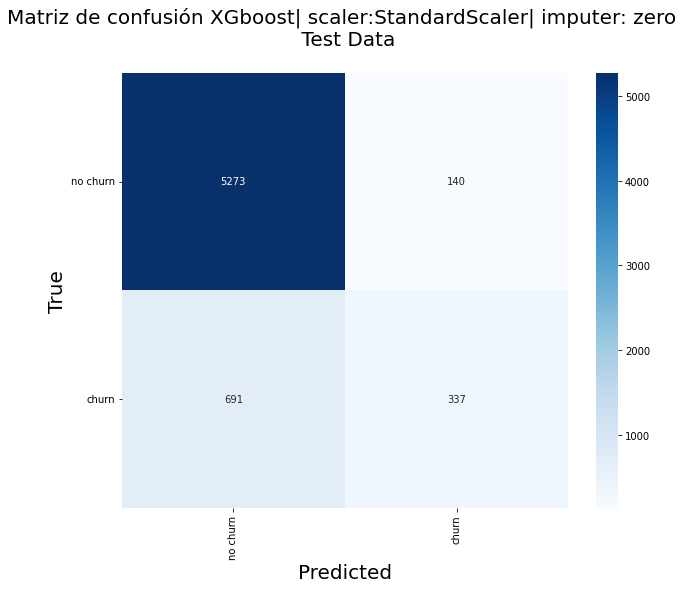

In [29]:
## Matriz de confusión para el mejor modelo
get_confusion_plot(test['churn'].values.ravel(),xgb.predict(test.drop(columns=["churn","Asegurado__c"])),class_names=['no churn','churn'],title="Matriz de confusión XGboost| scaler:StandardScaler| imputer: zero \n Test Data\n")

## Otros enfoques de entrenamiento

Debido a la gran variedad de modelos y de técnicas para intentar maximizar el desempeño de los mismos, es necesario explorarlas. Dependiendo del enfoque, tiempo disponible u otros factores, se pueden abordar más modelos o modificaciones de los modelos evaluados y comparar los resultados. A continuación intentamos evaluar el desempeño, usando otras técnicas de imputación de datos y enfoque para el escalado de variables numéricas.


In [45]:
xgb_2=get_classifier_model("xgboost",scaler_method="minmax",imputer="median")
logistic_2=get_classifier_model("logistic_regression",scaler_method="minmax",imputer="median")
lightgbm_2=get_classifier_model("lightgbm",scaler_method="minmax",imputer="median")

In [47]:
xgb_2.fit(X_train,Y_train.ravel())

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[Pipeline] ........... (step 1 of 3) Processing cleaner, total=   0.1s
[Pipeline] ............... (step 2 of 3) Processing pca, total=   0.2s
[Pipeline] ............. (step 3 of 3) Processing model, total=  55.0s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cleaner',
                                        ColumnTransformer(sparse_threshold=0,
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['n_prod_prev',
                                                                          'total_siniestros',
                                                                          'total_pagado_smmlv',
                                                                          'anios_ultimo_siniestro',
                                                                          'Activos__c',
                                                                          'AnnualRevenue',
                                                                          'MontoAnual__c',
                                                                          'OtrosIngresos__c',
                                                                          'Egr...
                                                                          'TipoVehiculo__c',
                                                                          'EstadoCivil__pc',
                                                                          'Genero__pc',
                                                                          'ciudad_name'])])),
                                       ('pca', PCA()),
                                       ('model', GradientBoostingClassifier())],
                                verbose=True),
             n_jobs=-1,
             param_grid={'model__learning_rate': [0.01],
                         'model__max_depth': [5, 10, 20],
                         'model__min_samples_split': [2, 5],
                         'model__n_estimators': [50, 100, 250],
                         'model__subsample': [0.9, 1],
                         'pca__n_components': [10, 20]},
             scoring='f1', verbose=True)

In [48]:
logistic_2.fit(X_train,Y_train.ravel())

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[Pipeline] ........... (step 1 of 3) Processing cleaner, total=   0.1s
[Pipeline] ............... (step 2 of 3) Processing pca, total=   0.2s
[Pipeline] ............. (step 3 of 3) Processing model, total=   0.4s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cleaner',
                                        ColumnTransformer(sparse_threshold=0,
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['n_prod_prev',
                                                                          'total_siniestros',
                                                                          'total_pagado_smmlv',
                                                                          'anios_ultimo_siniestro',
                                                                          'Activos__c',
                                                                          'AnnualRevenue',
                                                                          'MontoAnual__c',
                                                                          'OtrosIngresos__c',
                                                                          'Egr...
                                                                          'tipo_prod_desc',
                                                                          'ClaseVehiculo__c',
                                                                          'TipoVehiculo__c',
                                                                          'EstadoCivil__pc',
                                                                          'Genero__pc',
                                                                          'ciudad_name'])])),
                                       ('pca', PCA()),
                                       ('model',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=4000,
                                                           solver='saga'))],
                                verbose=True),
             n_jobs=-1,
             param_grid={'model__l1_ratio': [0.1, 0.3, 0.5, 0.8, 1],
                         'model__penalty': ['elasticnet'],
                         'pca__n_components': [10, 20]},
             scoring='f1', verbose=True)

In [49]:
lightgbm_2.fit(X_train,Y_train.ravel())

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits
[Pipeline] ........... (step 1 of 3) Processing cleaner, total=   0.1s
[Pipeline] ............... (step 2 of 3) Processing pca, total=   0.3s
[Pipeline] ............. (step 3 of 3) Processing model, total=   1.0s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cleaner',
                                        ColumnTransformer(sparse_threshold=0,
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['n_prod_prev',
                                                                          'total_siniestros',
                                                                          'total_pagado_smmlv',
                                                                          'anios_ultimo_siniestro',
                                                                          'Activos__c',
                                                                          'AnnualRevenue',
                                                                          'MontoAnual__c',
                                                                          'OtrosIngresos__c',
                                                                          'Egr...
                                       ('pca', PCA()),
                                       ('model', LGBMClassifier())],
                                verbose=True),
             n_jobs=-1,
             param_grid={'model__colsample_bytree': [0.8, 0.9],
                         'model__max_depth': [10, 15],
                         'model__n_estimators': [100, 150, 500],
                         'model__num_leaves': [10, 50],
                         'model__reg_alpha': [0.0, 1.1, 1.2],
                         'model__reg_lambda': [0.0, 1.1, 1.2],
                         'model__subsample': [0.9, 1],
                         'pca__n_components': [5, 10, 20]},
             scoring='f1', verbose=True)

In [34]:
print("===Métricas para XGboost===\n")
print("\n\t Training\n")
_=metrics(Y_train.ravel(),xgb_2.predict(X_train))
roc=roc_auc_score(Y_train.ravel(),xgb_2.predict_proba(X_train)[:,1])
print("ROC-AUC: {:.4f}\n".format(roc))
print("\n\t Test \n")
_=metrics(test['churn'].values.ravel(),xgb_2.predict(test.drop(columns=["churn","Asegurado__c"])))
roc=roc_auc_score(test['churn'].values.ravel(),xgb_2.predict_proba(test.drop(columns=["churn","Asegurado__c"]))[:,1])
print("ROC-AUC: {:.4f}\n".format(roc))
print("\n===Métricas para Regresión Logística===\n")
print("\n\t Training\n")
_=metrics(Y_train.ravel(),logistic_2.predict(X_train))
roc=roc_auc_score(Y_train.ravel(),logistic_2.predict_proba(X_train)[:,1])
print("ROC-AUC: {:.4f}\n".format(roc))
print("\n\t Test \n")
_=metrics(test['churn'].values.ravel(),logistic_2.predict(test.drop(columns=["churn","Asegurado__c"])))
roc=roc_auc_score(test['churn'].values.ravel(),logistic_2.predict_proba(test.drop(columns=["churn","Asegurado__c"]))[:,1])
print("ROC-AUC: {:.4f}\n".format(roc))
print("\n===Métricas para LightGBM===\n")
print("\n\t Training\n")
_=metrics(Y_train.ravel(),lightgbm_2.predict(X_train))
roc=roc_auc_score(Y_train.ravel(),lightgbm_2.predict_proba(X_train)[:,1])
print("ROC-AUC: {:.4f}\n".format(roc))
print("\n\t Test \n")
_=metrics(test['churn'].values.ravel(),lightgbm_2.predict(test.drop(columns=["churn","Asegurado__c"])))
roc=roc_auc_score(test['churn'].values.ravel(),lightgbm_2.predict_proba(test.drop(columns=["churn","Asegurado__c"]))[:,1])
print("ROC-AUC: {:.4f}\n".format(roc))

===Métricas para XGboost===


	 Training

 Accuracy:0.8546 
 Precision: 0.5831 
 Recall: 0.3366 
 Kappa: 0.3503 
 F1-Score: 0.4268 
ROC-AUC: 0.8213


	 Test 

 Accuracy:0.8359 
 Precision: 0.4767 
 Recall: 0.2879 
 Kappa: 0.2714 
 F1-Score: 0.3590 
ROC-AUC: 0.7921


===Métricas para Regresión Logística===


	 Training

 Accuracy:0.7808 
 Precision: 0.3955 
 Recall: 0.6868 
 Kappa: 0.3742 
 F1-Score: 0.5019 
ROC-AUC: 0.7826


	 Test 

 Accuracy:0.7850 
 Precision: 0.3989 
 Recall: 0.6848 
 Kappa: 0.3788 
 F1-Score: 0.5041 
ROC-AUC: 0.7848


===Métricas para LightGBM===


	 Training

 Accuracy:0.8812 
 Precision: 0.7528 
 Recall: 0.3891 
 Kappa: 0.4531 
 F1-Score: 0.5130 
ROC-AUC: 0.7847


	 Test 

 Accuracy:0.8583 
 Precision: 0.6044 
 Recall: 0.3239 
 Kappa: 0.3493 
 F1-Score: 0.4218 
ROC-AUC: 0.7410



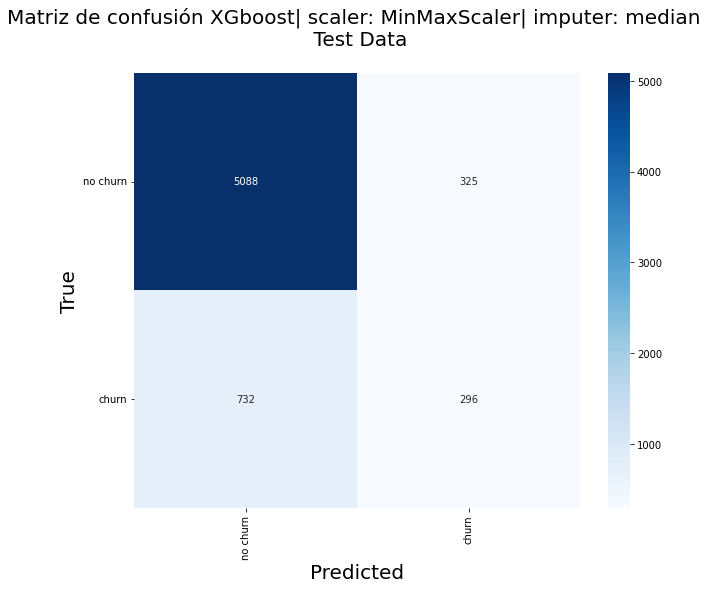

In [50]:
get_confusion_plot(test['churn'].values.ravel(),xgb_2.predict(test.drop(columns=["churn","Asegurado__c"])),class_names=['no churn','churn'],title="Matriz de confusión XGboost| scaler: MinMaxScaler| imputer: median \n Test Data\n")

## Discusión

- Vemos que el mejor modelo fue la versión inicial de XGBoost, el cual presenta los mejores indicadores de desempeño. Sin embargo, cabe la posibilidad de explorar modelos adicionales o mas hiperparámetros de los modelos propuestos.

- Existen otras posibilidades de exploración en cuanto a encontrar el mejor modelo, y es hacer un análisis con diferentes puntos de corte para la probabilidad. Actualmente para los modelos logísticos, se asume el churn si la probabilidad que arroja el modelo es mayor a 0.5. Sin embargo, este valor puede modificarse para evaluar el comportamiento de las métricas con puntos de corte diferentes.


### Exportar modelos para futuro uso

In [52]:
import pickle
import os

if not os.path.isdir("models"):
    os.mkdir("models")

with open("models/xgbmodel.pickle","wb") as f:
    pickle.dump(xgb,f)

with open("models/xgbmodel2.pickle","wb") as f:
    pickle.dump(xgb_2,f)

with open("models/logistic.pickle","wb") as f:
    pickle.dump(logistic,f)

with open("models/lightgbm.pickle","wb") as f:
    pickle.dump(lightgbm,f)

In [13]:
##reutilizar | leer modelos guardados
import pickle
with open("models/xgbmodel.pickle", 'rb') as f:
    xgb = pickle.load(f)